In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_data():
    mnist = datasets.fetch_openml("mnist_784", version=1, as_frame=False)
    X, y = mnist.data, mnist.target
    y = y.astype(np.int32)  # Convert target to integers
    return X, y


def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def avg_pooling(image, pool_size):
    pooled_height = image.shape[0] // pool_size[0]
    pooled_width = image.shape[1] // pool_size[1]
    pooled_image = np.zeros((pooled_height, pooled_width))

    for i in range(pooled_height):
        for j in range(pooled_width):
            start_i, end_i = i * pool_size[0], (i + 1) * pool_size[0]
            start_j, end_j = j * pool_size[1], (j + 1) * pool_size[1]
            pooled_image[i, j] = np.mean(image[start_i:end_i, start_j:end_j])

    return pooled_image


def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [2]:
import tqdm

# Load and split the data
X, y = load_data()

pool_size = 3
X_pooled = np.zeros((X.shape[0], (28 // pool_size) * (28 // pool_size)))
for i in tqdm.tqdm(range(X.shape[0])):
    image = X[i].reshape(28, 28)
    pooled_image = avg_pooling(image, (pool_size, pool_size))
    X_pooled[i] = pooled_image.flatten()

X_train, X_test, y_train, y_test = split_data(X_pooled, y)

# Preprocess the data
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
100%|██████████| 70000/70000 [00:52<00:00, 1335.86it/s]


In [3]:
import sys
sys.path.append('D:\calvera\src')

In [4]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [5]:
import torch

from neural_bandits.algorithms.neural_ucb_bandit import NeuralUCB
from neural_bandits.trainers.neural_ucb_trainer import NeuralUCBTrainer
from neural_bandits.utils.multiclass import MultiClassContextualiser

def train_neural_ucb_mnist(X_train_scaled, y_train, n_samples: int = 10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_features = X_train_scaled.shape[1]
    n_arms = 10

    network = Network(n_features * n_arms, hidden_size=100)
    
    # Initialize bandit
    bandit = NeuralUCB(
        network=network,
        n_arms=n_arms,
        n_features=n_features * n_arms,
        lambda_=0.00001,
        nu=0.00001,
    ).to(device)
    
    trainer = NeuralUCBTrainer(eta=0.01)
    mc_contextualiser = MultiClassContextualiser(n_arms)
    
    total_regret = []
    
    for t in tqdm.tqdm(range(n_samples)):
        x_tensor = torch.tensor(X_train_scaled[t], dtype=torch.float32).to(device).reshape(1, -1)
        contextualised_actions = mc_contextualiser.contextualise(x_tensor)
        # print("contextualised_actions.shape: ", contextualised_actions.shape)
        
        # Select action
        ucb_scores = bandit(contextualised_actions)
        chosen_arm = torch.argmax(ucb_scores, dim=1).item()
        
        # Get reward
        reward = 1.0 if y_train[t] == chosen_arm else 0.0
        reward = torch.tensor([reward], dtype=torch.float32, device=device).reshape(1, -1)
        total_regret.append(1 - reward.item())
        
        # Extract features for chosen arm
        contextualised_actions = contextualised_actions.squeeze(0)
        chosen_features = contextualised_actions[chosen_arm]
        # print("chosen_features.shape: ", chosen_features.shape)
        
        # Update bandit
        if t < 1000:
            bandit = trainer.update(bandit, reward, chosen_features)
        else:
            if t % 100 == 0:
                bandit = trainer.update(bandit, reward, chosen_features)

        if t % 100 == 0:
            print(f"Step {t}:")
            print(f"UCB Scores: {ucb_scores}")
            print(f"Chosen arm: {chosen_arm}")
            print(f"True label: {y_train[t]}")
            print(f"Average regret: {sum(total_regret)/(t+1)}")
    
    return bandit, total_regret

In [6]:
# Train the neural UCB bandit
bandit, regret = train_neural_ucb_mnist(X_train_scaled, y_train)

# Print results
print("Total regret:", sum(regret))
print("Average regret:", sum(regret) / len(regret))

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
  0%|          | 10/10000 [00:02<25:40,  6.49it/s] 

Step 0:
UCB Scores: tensor([[0.1010, 0.1014, 0.1000, 0.0960, 0.0986, 0.1005, 0.0998, 0.1044, 0.1001,
         0.0982]])
Chosen arm: 7
True label: 5
Average regret: 1.0


  1%|          | 101/10000 [00:11<26:27,  6.23it/s]

Step 100:
UCB Scores: tensor([[0.1094, 0.0768, 0.1090, 0.0965, 0.1362, 0.0920, 0.0935, 0.1040, 0.0964,
         0.0861]])
Chosen arm: 4
True label: 0
Average regret: 0.8217821782178217


  2%|▏         | 202/10000 [00:32<27:09,  6.01it/s]  

Step 200:
UCB Scores: tensor([[0.0998, 0.0602, 0.1017, 0.0952, 0.1442, 0.1089, 0.1037, 0.1022, 0.0895,
         0.0947]])
Chosen arm: 4
True label: 6
Average regret: 0.7810945273631841


  3%|▎         | 301/10000 [00:59<47:51,  3.38it/s]  

Step 300:
UCB Scores: tensor([[0.0887, 0.0733, 0.1152, 0.1150, 0.0829, 0.0756, 0.1172, 0.1136, 0.1120,
         0.1064]])
Chosen arm: 6
True label: 3
Average regret: 0.7342192691029901


  4%|▍         | 401/10000 [01:36<1:03:19,  2.53it/s]

Step 400:
UCB Scores: tensor([[0.0871, 0.0752, 0.1077, 0.1200, 0.0912, 0.0804, 0.1089, 0.1008, 0.1259,
         0.1028]])
Chosen arm: 8
True label: 7
Average regret: 0.685785536159601


  5%|▌         | 501/10000 [02:15<1:00:00,  2.64it/s]

Step 500:
UCB Scores: tensor([[0.0664, 0.2211, 0.0910, 0.0865, 0.0896, 0.0768, 0.0996, 0.0923, 0.0818,
         0.0949]])
Chosen arm: 1
True label: 1
Average regret: 0.654690618762475


  6%|▌         | 601/10000 [02:58<1:26:33,  1.81it/s]

Step 600:
UCB Scores: tensor([[0.1010, 0.0828, 0.0993, 0.0850, 0.0856, 0.1344, 0.0999, 0.1006, 0.1154,
         0.0960]])
Chosen arm: 5
True label: 7
Average regret: 0.6123128119800333


  7%|▋         | 701/10000 [03:46<1:28:33,  1.75it/s]

Step 700:
UCB Scores: tensor([[0.0943, 0.2012, 0.0849, 0.1043, 0.1001, 0.0747, 0.0771, 0.0556, 0.1120,
         0.0959]])
Chosen arm: 1
True label: 1
Average regret: 0.5592011412268189


  8%|▊         | 801/10000 [04:41<1:21:08,  1.89it/s]

Step 800:
UCB Scores: tensor([[0.1417, 0.0775, 0.0787, 0.1833, 0.0499, 0.1192, 0.0821, 0.1020, 0.0698,
         0.0956]])
Chosen arm: 3
True label: 3
Average regret: 0.5156054931335831


  9%|▉         | 901/10000 [05:36<1:24:46,  1.79it/s]

Step 900:
UCB Scores: tensor([[0.1127, 0.0325, 0.0678, 0.1444, 0.0552, 0.1837, 0.1037, 0.0785, 0.0889,
         0.1325]])
Chosen arm: 5
True label: 5
Average regret: 0.4739178690344062


 10%|█         | 1043/10000 [06:35<04:36, 32.44it/s]  

Step 1000:
UCB Scores: tensor([[0.0731, 0.1887, 0.1269, 0.0704, 0.0851, 0.0545, 0.0855, 0.0935, 0.1240,
         0.0983]])
Chosen arm: 1
True label: 1
Average regret: 0.4435564435564436


 11%|█▏        | 1136/10000 [06:36<02:14, 65.77it/s]

Step 1100:
UCB Scores: tensor([[0.0781, 0.1091, 0.0964, 0.0665, 0.1181, 0.0926, 0.0905, 0.1589, 0.0833,
         0.1064]])
Chosen arm: 7
True label: 9
Average regret: 0.41326067211625794


 12%|█▏        | 1238/10000 [06:37<01:47, 81.33it/s] 

Step 1200:
UCB Scores: tensor([[0.0695, 0.0797, 0.0885, 0.1491, 0.0453, 0.0941, 0.0782, 0.1482, 0.0886,
         0.1588]])
Chosen arm: 9
True label: 9
Average regret: 0.3938384679433805


 13%|█▎        | 1340/10000 [06:38<01:43, 83.31it/s] 

Step 1300:
UCB Scores: tensor([[0.0939, 0.0887, 0.0788, 0.2588, 0.0689, 0.1090, 0.0894, 0.1002, 0.0555,
         0.0567]])
Chosen arm: 3
True label: 3
Average regret: 0.3789392774788624


 14%|█▍        | 1430/10000 [06:39<01:54, 74.87it/s] 

Step 1400:
UCB Scores: tensor([[0.1043, 0.0525, 0.0634, 0.1764, 0.0632, 0.2162, 0.0916, 0.0741, 0.1036,
         0.0546]])
Chosen arm: 5
True label: 5
Average regret: 0.3654532476802284


 15%|█▌        | 1525/10000 [06:40<01:52, 75.29it/s] 

Step 1500:
UCB Scores: tensor([[0.1484, 0.0946, 0.0742, 0.0323, 0.2167, 0.0329, 0.1305, 0.0892, 0.0586,
         0.1226]])
Chosen arm: 4
True label: 7
Average regret: 0.3557628247834777


 16%|█▋        | 1644/10000 [06:41<01:25, 97.44it/s] 

Step 1600:
UCB Scores: tensor([[0.0668, 0.0993, 0.0590, 0.1231, 0.1426, 0.1207, 0.0976, 0.1068, 0.1473,
         0.0368]])
Chosen arm: 8
True label: 8
Average regret: 0.3435352904434728


 17%|█▋        | 1721/10000 [06:42<01:46, 77.67it/s] 

Step 1700:
UCB Scores: tensor([[0.1394, 0.0489, 0.1326, 0.1010, 0.0706, 0.0734, 0.1065, 0.1472, 0.1005,
         0.0799]])
Chosen arm: 7
True label: 6
Average regret: 0.3321575543797766


 18%|█▊        | 1834/10000 [06:43<01:42, 79.82it/s] 

Step 1800:
UCB Scores: tensor([[0.0884, 0.0898, 0.0796, 0.0863, 0.1049, 0.1166, 0.1134, 0.1022, 0.1133,
         0.1056]])
Chosen arm: 5
True label: 4
Average regret: 0.3242642976124375


 19%|█▉        | 1933/10000 [06:45<01:39, 81.32it/s] 

Step 1900:
UCB Scores: tensor([[0.1005, 0.0671, 0.0864, 0.1128, 0.0489, 0.0903, 0.1087, 0.0796, 0.2110,
         0.0947]])
Chosen arm: 8
True label: 8
Average regret: 0.3145712782745923


 20%|██        | 2034/10000 [06:46<01:37, 81.83it/s] 

Step 2000:
UCB Scores: tensor([[0.0747, 0.0701, 0.0947, 0.0608, 0.1961, 0.0601, 0.0869, 0.0637, 0.0655,
         0.2273]])
Chosen arm: 9
True label: 4
Average regret: 0.30684657671164417


 21%|██▏       | 2128/10000 [06:47<01:39, 79.02it/s] 

Step 2100:
UCB Scores: tensor([[0.1037, 0.0673, 0.0860, 0.2610, 0.0462, 0.0498, 0.1082, 0.0653, 0.0611,
         0.1514]])
Chosen arm: 3
True label: 3
Average regret: 0.29985721085197525


 22%|██▏       | 2230/10000 [06:48<01:35, 81.48it/s] 

Step 2200:
UCB Scores: tensor([[0.0765, 0.0341, 0.0871, 0.0500, 0.0643, 0.0848, 0.0905, 0.3183, 0.1027,
         0.0918]])
Chosen arm: 7
True label: 7
Average regret: 0.2921399363925488


 23%|██▎       | 2327/10000 [06:49<01:34, 81.42it/s] 

Step 2300:
UCB Scores: tensor([[0.0634, 0.0945, 0.2576, 0.1263, 0.0490, 0.0853, 0.0845, 0.0668, 0.0830,
         0.0897]])
Chosen arm: 2
True label: 2
Average regret: 0.28770099956540635


 24%|██▍       | 2422/10000 [06:50<01:38, 76.72it/s] 

Step 2400:
UCB Scores: tensor([[0.1918, 0.0587, 0.0825, 0.1234, 0.0791, 0.0785, 0.1490, 0.0692, 0.0822,
         0.0856]])
Chosen arm: 0
True label: 0
Average regret: 0.280716368179925


 25%|██▌       | 2539/10000 [06:51<01:32, 80.91it/s] 

Step 2500:
UCB Scores: tensor([[0.2622, 0.0615, 0.1475, 0.0595, 0.0960, 0.1227, 0.0931, 0.0747, 0.0469,
         0.0359]])
Chosen arm: 0
True label: 0
Average regret: 0.2762894842063175


 26%|██▋       | 2635/10000 [06:52<01:33, 78.50it/s] 

Step 2600:
UCB Scores: tensor([[0.0841, 0.0937, 0.0853, 0.1996, 0.0539, 0.1440, 0.0741, 0.1015, 0.0849,
         0.0788]])
Chosen arm: 3
True label: 3
Average regret: 0.2710495963091119


 27%|██▋       | 2726/10000 [06:53<01:34, 76.84it/s] 

Step 2700:
UCB Scores: tensor([[0.0877, 0.1888, 0.0891, 0.1043, 0.0701, 0.1392, 0.0615, 0.0682, 0.1042,
         0.0869]])
Chosen arm: 1
True label: 1
Average regret: 0.2669381710477601


 28%|██▊       | 2825/10000 [06:54<01:28, 81.05it/s] 

Step 2800:
UCB Scores: tensor([[0.0657, 0.1898, 0.1592, 0.0919, 0.0847, 0.0377, 0.0840, 0.1256, 0.0710,
         0.0904]])
Chosen arm: 1
True label: 1
Average regret: 0.26312031417350945


 29%|██▉       | 2939/10000 [06:56<01:16, 92.38it/s] 

Step 2900:
UCB Scores: tensor([[0.2059, 0.0434, 0.0983, 0.0355, 0.1539, 0.0296, 0.1341, 0.1287, 0.0971,
         0.0736]])
Chosen arm: 0
True label: 0
Average regret: 0.26025508445363665


 30%|███       | 3030/10000 [06:57<01:28, 78.82it/s] 

Step 3000:
UCB Scores: tensor([[0.0825, 0.1356, 0.1367, 0.2007, 0.0749, 0.1048, 0.0530, 0.0642, 0.0653,
         0.0824]])
Chosen arm: 3
True label: 3
Average regret: 0.25558147284238586


 31%|███       | 3124/10000 [06:58<01:27, 78.41it/s] 

Step 3100:
UCB Scores: tensor([[0.0723, 0.0948, 0.0874, 0.0794, 0.1496, 0.0462, 0.1199, 0.1938, 0.0820,
         0.0746]])
Chosen arm: 7
True label: 9
Average regret: 0.25185424056755884


 32%|███▏      | 3243/10000 [06:59<01:09, 97.67it/s] 

Step 3200:
UCB Scores: tensor([[0.0597, 0.0614, 0.0635, 0.1392, 0.2520, 0.0314, 0.0964, 0.1356, 0.0398,
         0.1211]])
Chosen arm: 4
True label: 4
Average regret: 0.24742268041237114


 33%|███▎      | 3338/10000 [07:00<01:11, 92.90it/s] 

Step 3300:
UCB Scores: tensor([[0.0376, 0.2180, 0.0724, 0.1103, 0.0820, 0.0735, 0.1224, 0.0900, 0.1456,
         0.0483]])
Chosen arm: 1
True label: 1
Average regret: 0.2438654953044532


 34%|███▍      | 3438/10000 [07:01<01:19, 82.25it/s] 

Step 3400:
UCB Scores: tensor([[0.0703, 0.2373, 0.1460, 0.0947, 0.0816, 0.0312, 0.0849, 0.0837, 0.1006,
         0.0698]])
Chosen arm: 1
True label: 1
Average regret: 0.24375183769479564


 35%|███▌      | 3529/10000 [07:02<01:30, 71.14it/s] 

Step 3500:
UCB Scores: tensor([[0.0779, 0.0498, 0.1551, 0.2223, 0.0673, 0.1500, 0.0778, 0.0713, 0.0699,
         0.0586]])
Chosen arm: 3
True label: 3
Average regret: 0.24107397886318194


 36%|███▋      | 3639/10000 [07:04<01:18, 81.10it/s] 

Step 3600:
UCB Scores: tensor([[0.0666, 0.1093, 0.1877, 0.0618, 0.0651, 0.0805, 0.1390, 0.1083, 0.0855,
         0.0961]])
Chosen arm: 2
True label: 2
Average regret: 0.24076645376284364


 37%|███▋      | 3733/10000 [07:05<01:22, 76.34it/s] 

Step 3700:
UCB Scores: tensor([[0.0580, 0.1113, 0.0859, 0.1509, 0.0733, 0.0632, 0.0574, 0.0921, 0.1370,
         0.1709]])
Chosen arm: 9
True label: 3
Average regret: 0.2391245609294785


 38%|███▊      | 3827/10000 [07:06<01:22, 75.01it/s] 

Step 3800:
UCB Scores: tensor([[0.0810, 0.0582, 0.1539, 0.0551, 0.1352, 0.0810, 0.1398, 0.0538, 0.0849,
         0.1572]])
Chosen arm: 9
True label: 2
Average regret: 0.23520126282557222


 39%|███▉      | 3929/10000 [07:07<01:14, 81.50it/s] 

Step 3900:
UCB Scores: tensor([[0.0897, 0.1035, 0.1394, 0.1226, 0.0708, 0.1106, 0.0800, 0.0780, 0.1158,
         0.0895]])
Chosen arm: 2
True label: 8
Average regret: 0.23276083055626762


 40%|████      | 4042/10000 [07:08<01:02, 94.68it/s] 

Step 4000:
UCB Scores: tensor([[0.1266, 0.0884, 0.0538, 0.0426, 0.0866, 0.2623, 0.0658, 0.0920, 0.1291,
         0.0529]])
Chosen arm: 5
True label: 5
Average regret: 0.23019245188702825


 41%|████▏     | 4132/10000 [07:09<01:19, 74.11it/s] 

Step 4100:
UCB Scores: tensor([[0.1434, 0.0870, 0.1039, 0.0652, 0.1458, 0.0827, 0.0816, 0.1102, 0.0821,
         0.0981]])
Chosen arm: 4
True label: 4
Average regret: 0.22799317239697633


 42%|████▏     | 4226/10000 [07:10<01:31, 63.00it/s] 

Step 4200:
UCB Scores: tensor([[0.0539, 0.1734, 0.1004, 0.1046, 0.0919, 0.0594, 0.1055, 0.1269, 0.0876,
         0.0962]])
Chosen arm: 1
True label: 1
Average regret: 0.22589859557248274


 43%|████▎     | 4319/10000 [07:12<01:19, 71.43it/s] 

Step 4300:
UCB Scores: tensor([[0.0695, 0.0516, 0.0951, 0.0561, 0.2500, 0.0925, 0.0797, 0.0912, 0.1090,
         0.1053]])
Chosen arm: 4
True label: 4
Average regret: 0.2239014182748198


 44%|████▍     | 4428/10000 [07:13<01:17, 71.92it/s] 

Step 4400:
UCB Scores: tensor([[0.2432, 0.0238, 0.1078, 0.0684, 0.0767, 0.0731, 0.1015, 0.0719, 0.0939,
         0.1396]])
Chosen arm: 0
True label: 0
Average regret: 0.2233583276528062


 45%|████▌     | 4536/10000 [07:14<01:11, 76.58it/s] 

Step 4500:
UCB Scores: tensor([[0.0673, 0.0492, 0.0774, 0.0854, 0.0666, 0.0745, 0.0801, 0.0997, 0.1174,
         0.2823]])
Chosen arm: 9
True label: 9
Average regret: 0.22017329482337258


 46%|████▋     | 4629/10000 [07:15<01:11, 75.08it/s] 

Step 4600:
UCB Scores: tensor([[0.0862, 0.1251, 0.2224, 0.0711, 0.0473, 0.1001, 0.0846, 0.1050, 0.0836,
         0.0746]])
Chosen arm: 2
True label: 2
Average regret: 0.21886546402955878


 47%|████▋     | 4723/10000 [07:16<01:12, 73.09it/s] 

Step 4700:
UCB Scores: tensor([[0.2111, 0.0572, 0.0847, 0.1516, 0.1068, 0.1065, 0.0686, 0.0840, 0.0574,
         0.0722]])
Chosen arm: 0
True label: 0
Average regret: 0.21782599446926185


 48%|████▊     | 4833/10000 [07:17<01:08, 75.45it/s] 

Step 4800:
UCB Scores: tensor([[0.1172, 0.0506, 0.0839, 0.1327, 0.0532, 0.1486, 0.1455, 0.0872, 0.0741,
         0.1070]])
Chosen arm: 5
True label: 5
Average regret: 0.2164132472401583


 49%|████▉     | 4941/10000 [07:19<00:55, 91.81it/s] 

Step 4900:
UCB Scores: tensor([[0.0762, 0.0288, 0.1091, 0.0606, 0.1277, 0.0796, 0.2136, 0.1018, 0.0754,
         0.1271]])
Chosen arm: 6
True label: 6
Average regret: 0.21444603142215873


 50%|█████     | 5019/10000 [07:20<01:18, 63.48it/s] 

Step 5000:
UCB Scores: tensor([[0.0542, 0.2463, 0.0924, 0.1173, 0.0859, 0.0453, 0.0926, 0.0963, 0.1032,
         0.0665]])
Chosen arm: 1
True label: 1
Average regret: 0.21355728854229153


 51%|█████▏    | 5139/10000 [07:21<01:00, 80.04it/s] 

Step 5100:
UCB Scores: tensor([[0.0668, 0.1334, 0.1080, 0.0806, 0.0642, 0.0605, 0.0920, 0.0901, 0.1935,
         0.1110]])
Chosen arm: 8
True label: 8
Average regret: 0.21113507155459713


 52%|█████▏    | 5233/10000 [07:22<01:04, 74.43it/s] 

Step 5200:
UCB Scores: tensor([[0.0632, 0.1414, 0.0992, 0.1026, 0.0692, 0.0560, 0.0776, 0.2209, 0.0951,
         0.0748]])
Chosen arm: 7
True label: 7
Average regret: 0.20976735243222458


 53%|█████▎    | 5331/10000 [07:23<00:58, 79.36it/s] 

Step 5300:
UCB Scores: tensor([[0.0833, 0.0690, 0.0834, 0.2277, 0.1115, 0.1496, 0.0600, 0.0891, 0.0864,
         0.0400]])
Chosen arm: 3
True label: 3
Average regret: 0.20863987926806263


 54%|█████▍    | 5426/10000 [07:24<01:01, 73.83it/s] 

Step 5400:
UCB Scores: tensor([[0.0836, 0.0789, 0.2695, 0.0521, 0.0927, 0.0435, 0.0951, 0.1027, 0.0696,
         0.1123]])
Chosen arm: 2
True label: 2
Average regret: 0.20810960933160527


 55%|█████▌    | 5524/10000 [07:25<00:56, 78.94it/s] 

Step 5500:
UCB Scores: tensor([[0.0932, 0.1071, 0.0520, 0.0774, 0.0883, 0.2244, 0.0623, 0.1076, 0.1545,
         0.0331]])
Chosen arm: 5
True label: 5
Average regret: 0.20759861843301217


 56%|█████▋    | 5639/10000 [07:27<00:52, 82.44it/s] 

Step 5600:
UCB Scores: tensor([[0.0913, 0.0766, 0.0744, 0.0716, 0.0451, 0.1563, 0.1044, 0.0340, 0.1324,
         0.2139]])
Chosen arm: 9
True label: 8
Average regret: 0.2054990180324942


 57%|█████▋    | 5730/10000 [07:28<00:55, 76.31it/s] 

Step 5700:
UCB Scores: tensor([[0.0601, 0.1038, 0.0613, 0.0970, 0.1739, 0.0766, 0.0962, 0.1582, 0.0998,
         0.0732]])
Chosen arm: 4
True label: 4
Average regret: 0.204525521838274


 58%|█████▊    | 5841/10000 [07:29<00:46, 89.70it/s] 

Step 5800:
UCB Scores: tensor([[0.1313, 0.0457, 0.0628, 0.0465, 0.1239, 0.1514, 0.1470, 0.1160, 0.0836,
         0.0918]])
Chosen arm: 5
True label: 4
Average regret: 0.2028960524047578


 59%|█████▉    | 5938/10000 [07:30<00:51, 79.34it/s] 

Step 5900:
UCB Scores: tensor([[0.1221, 0.0789, 0.0317, 0.0970, 0.0662, 0.1761, 0.0693, 0.1565, 0.1284,
         0.0739]])
Chosen arm: 5
True label: 5
Average regret: 0.2018301982714794


 60%|██████    | 6034/10000 [07:31<00:49, 80.19it/s] 

Step 6000:
UCB Scores: tensor([[0.0527, 0.0562, 0.0880, 0.0566, 0.2211, 0.0768, 0.1053, 0.1031, 0.1206,
         0.1198]])
Chosen arm: 4
True label: 4
Average regret: 0.20129978336943843


 61%|██████▏   | 6129/10000 [07:32<00:49, 78.49it/s] 

Step 6100:
UCB Scores: tensor([[0.0984, 0.0662, 0.0992, 0.2150, 0.0536, 0.1322, 0.1037, 0.0756, 0.0849,
         0.0713]])
Chosen arm: 3
True label: 3
Average regret: 0.20013112604491068


 62%|██████▏   | 6225/10000 [07:33<00:48, 77.45it/s] 

Step 6200:
UCB Scores: tensor([[0.1701, 0.0497, 0.0663, 0.0942, 0.0536, 0.1487, 0.1479, 0.0800, 0.0780,
         0.1114]])
Chosen arm: 0
True label: 0
Average regret: 0.1988388969521045


 63%|██████▎   | 6318/10000 [07:35<01:01, 59.92it/s] 

Step 6300:
UCB Scores: tensor([[0.0833, 0.0618, 0.0722, 0.0942, 0.0824, 0.1787, 0.0872, 0.0867, 0.1353,
         0.1182]])
Chosen arm: 5
True label: 8
Average regret: 0.19758768449452468


 64%|██████▍   | 6422/10000 [07:36<00:53, 66.90it/s] 

Step 6400:
UCB Scores: tensor([[0.0899, 0.0497, 0.1109, 0.2643, 0.0884, 0.1064, 0.0811, 0.0722, 0.0806,
         0.0564]])
Chosen arm: 3
True label: 3
Average regret: 0.19575066395875645


 65%|██████▌   | 6523/10000 [07:37<00:55, 62.81it/s] 

Step 6500:
UCB Scores: tensor([[0.1108, 0.1582, 0.0686, 0.1236, 0.0600, 0.1286, 0.0685, 0.0809, 0.0989,
         0.1019]])
Chosen arm: 1
True label: 8
Average regret: 0.19581602830333794


 66%|██████▋   | 6636/10000 [07:38<00:43, 78.16it/s] 

Step 6600:
UCB Scores: tensor([[0.0691, 0.1886, 0.1056, 0.1116, 0.0596, 0.0708, 0.1064, 0.0970, 0.1043,
         0.0869]])
Chosen arm: 1
True label: 8
Average regret: 0.1951219512195122


 67%|██████▋   | 6726/10000 [07:39<00:43, 75.69it/s] 

Step 6700:
UCB Scores: tensor([[0.0675, 0.2347, 0.1158, 0.1069, 0.0861, 0.0423, 0.0822, 0.1258, 0.0789,
         0.0598]])
Chosen arm: 1
True label: 1
Average regret: 0.19474705267870468


 68%|██████▊   | 6827/10000 [07:41<00:39, 79.33it/s] 

Step 6800:
UCB Scores: tensor([[0.0887, 0.0509, 0.1024, 0.2345, 0.0873, 0.1751, 0.0663, 0.1078, 0.0555,
         0.0316]])
Chosen arm: 3
True label: 3
Average regret: 0.1942361417438612


 69%|██████▉   | 6926/10000 [07:42<00:38, 79.71it/s] 

Step 6900:
UCB Scores: tensor([[0.0971, 0.0896, 0.0865, 0.1197, 0.0768, 0.1375, 0.0853, 0.0765, 0.1744,
         0.0566]])
Chosen arm: 8
True label: 8
Average regret: 0.19388494421098393


 70%|███████   | 7017/10000 [07:43<00:41, 72.40it/s] 

Step 7000:
UCB Scores: tensor([[0.2350, 0.0579, 0.1041, 0.1111, 0.0836, 0.0627, 0.0929, 0.0816, 0.0963,
         0.0748]])
Chosen arm: 0
True label: 0
Average regret: 0.19382945293529497


 71%|███████▏  | 7134/10000 [07:44<00:36, 79.32it/s] 

Step 7100:
UCB Scores: tensor([[0.1417, 0.0570, 0.0968, 0.0891, 0.0859, 0.1026, 0.0845, 0.0654, 0.1762,
         0.1009]])
Chosen arm: 8
True label: 8
Average regret: 0.19278974792282777


 72%|███████▏  | 7224/10000 [07:45<00:37, 73.81it/s] 

Step 7200:
UCB Scores: tensor([[0.0782, 0.0830, 0.1022, 0.1596, 0.1432, 0.0826, 0.0894, 0.1238, 0.0686,
         0.0695]])
Chosen arm: 3
True label: 3
Average regret: 0.19205665879738926


 73%|███████▎  | 7324/10000 [07:46<00:33, 79.99it/s] 

Step 7300:
UCB Scores: tensor([[0.1068, 0.1109, 0.1118, 0.0964, 0.0997, 0.0604, 0.1049, 0.0719, 0.0951,
         0.1421]])
Chosen arm: 9
True label: 2
Average regret: 0.19161758663196823


 74%|███████▍  | 7426/10000 [07:47<00:31, 81.89it/s] 

Step 7400:
UCB Scores: tensor([[0.1035, 0.0418, 0.0994, 0.1093, 0.0786, 0.0830, 0.1060, 0.0702, 0.1395,
         0.1688]])
Chosen arm: 9
True label: 8
Average regret: 0.1915957303067153


 75%|███████▌  | 7524/10000 [07:48<00:30, 80.47it/s] 

Step 7500:
UCB Scores: tensor([[0.0914, 0.0721, 0.0802, 0.0522, 0.1124, 0.0604, 0.0940, 0.0625, 0.1288,
         0.2461]])
Chosen arm: 9
True label: 9
Average regret: 0.1907745633915478


 76%|███████▋  | 7625/10000 [07:49<00:29, 80.85it/s] 

Step 7600:
UCB Scores: tensor([[0.2351, 0.0534, 0.0892, 0.0694, 0.0703, 0.0778, 0.1156, 0.0598, 0.1464,
         0.0830]])
Chosen arm: 0
True label: 0
Average regret: 0.19023812656229444


 77%|███████▋  | 7740/10000 [07:51<00:24, 92.24it/s] 

Step 7700:
UCB Scores: tensor([[0.1006, 0.0248, 0.0558, 0.1868, 0.0690, 0.1932, 0.0528, 0.1154, 0.1780,
         0.0237]])
Chosen arm: 5
True label: 5
Average regret: 0.18958576808206726


 78%|███████▊  | 7838/10000 [07:52<00:25, 83.53it/s] 

Step 7800:
UCB Scores: tensor([[0.0815, 0.1013, 0.0807, 0.2209, 0.0794, 0.1522, 0.0733, 0.1196, 0.0432,
         0.0480]])
Chosen arm: 3
True label: 3
Average regret: 0.18895013459812846


 79%|███████▉  | 7934/10000 [07:53<00:26, 79.04it/s] 

Step 7900:
UCB Scores: tensor([[0.0907, 0.1515, 0.1444, 0.0680, 0.0853, 0.0679, 0.1879, 0.0463, 0.0734,
         0.0846]])
Chosen arm: 6
True label: 2
Average regret: 0.18871028983672952


 80%|████████  | 8032/10000 [07:54<00:25, 78.36it/s] 

Step 8000:
UCB Scores: tensor([[0.2539, 0.0365, 0.0895, 0.0768, 0.0932, 0.1093, 0.0768, 0.0923, 0.0901,
         0.0816]])
Chosen arm: 0
True label: 0
Average regret: 0.18810148731408574


 81%|████████▏ | 8128/10000 [07:55<00:23, 78.77it/s] 

Step 8100:
UCB Scores: tensor([[0.0547, 0.2122, 0.0778, 0.1119, 0.0700, 0.0656, 0.1375, 0.0901, 0.1412,
         0.0391]])
Chosen arm: 1
True label: 1
Average regret: 0.18750771509690162


 82%|████████▏ | 8242/10000 [07:56<00:18, 92.70it/s] 

Step 8200:
UCB Scores: tensor([[0.0850, 0.0989, 0.1023, 0.0794, 0.2535, 0.0482, 0.0966, 0.0708, 0.0512,
         0.1143]])
Chosen arm: 4
True label: 4
Average regret: 0.1871722960614559


 83%|████████▎ | 8346/10000 [07:57<00:16, 102.53it/s]

Step 8300:
UCB Scores: tensor([[0.0516, 0.2310, 0.0897, 0.0921, 0.0845, 0.0746, 0.1073, 0.1200, 0.0807,
         0.0685]])
Chosen arm: 1
True label: 1
Average regret: 0.18708589326587158


 84%|████████▍ | 8418/10000 [07:59<00:22, 71.23it/s] 

Step 8400:
UCB Scores: tensor([[0.0704, 0.0665, 0.0690, 0.0873, 0.1193, 0.0908, 0.1227, 0.1018, 0.0705,
         0.2017]])
Chosen arm: 9
True label: 4
Average regret: 0.18664444708963218


 85%|████████▌ | 8534/10000 [08:00<00:18, 77.50it/s] 

Step 8500:
UCB Scores: tensor([[0.0993, 0.0558, 0.1209, 0.1202, 0.0706, 0.0685, 0.0774, 0.2108, 0.1106,
         0.0659]])
Chosen arm: 7
True label: 7
Average regret: 0.18527232090342313


 86%|████████▌ | 8623/10000 [08:01<00:20, 67.64it/s] 

Step 8600:
UCB Scores: tensor([[0.0611, 0.2311, 0.1210, 0.1006, 0.0897, 0.0388, 0.0846, 0.1359, 0.0763,
         0.0609]])
Chosen arm: 1
True label: 1
Average regret: 0.18474595977211952


 87%|████████▋ | 8734/10000 [08:02<00:16, 78.01it/s] 

Step 8700:
UCB Scores: tensor([[0.0572, 0.1106, 0.1256, 0.0963, 0.0831, 0.0806, 0.0848, 0.0985, 0.2097,
         0.0536]])
Chosen arm: 8
True label: 8
Average regret: 0.18434662682450292


 88%|████████▊ | 8827/10000 [08:03<00:15, 73.72it/s] 

Step 8800:
UCB Scores: tensor([[0.1047, 0.0581, 0.1209, 0.0626, 0.1090, 0.1501, 0.1279, 0.1024, 0.0818,
         0.0825]])
Chosen arm: 5
True label: 6
Average regret: 0.18338825133507555


 89%|████████▉ | 8923/10000 [08:04<00:13, 79.03it/s] 

Step 8900:
UCB Scores: tensor([[0.1457, 0.0766, 0.1158, 0.0544, 0.0844, 0.0659, 0.1302, 0.1498, 0.0793,
         0.0979]])
Chosen arm: 7
True label: 6
Average regret: 0.18391192000898776


 90%|█████████ | 9035/10000 [08:05<00:11, 82.03it/s] 

Step 9000:
UCB Scores: tensor([[0.0997, 0.0811, 0.2227, 0.1159, 0.0891, 0.0747, 0.0911, 0.0734, 0.0657,
         0.0865]])
Chosen arm: 2
True label: 2
Average regret: 0.18386845906010443


 91%|█████████▏| 9129/10000 [08:07<00:11, 78.76it/s] 

Step 9100:
UCB Scores: tensor([[0.1121, 0.0544, 0.0475, 0.2358, 0.0627, 0.1393, 0.1456, 0.0730, 0.0795,
         0.0502]])
Chosen arm: 3
True label: 3
Average regret: 0.18272717283814965


 92%|█████████▏| 9222/10000 [08:08<00:10, 74.80it/s] 

Step 9200:
UCB Scores: tensor([[0.0692, 0.1933, 0.1258, 0.0793, 0.0925, 0.0518, 0.0820, 0.1087, 0.1084,
         0.0890]])
Chosen arm: 1
True label: 1
Average regret: 0.18313226823171394


 93%|█████████▎| 9336/10000 [08:09<00:08, 79.88it/s] 

Step 9300:
UCB Scores: tensor([[0.1728, 0.1000, 0.0763, 0.1145, 0.0569, 0.1611, 0.0819, 0.1086, 0.0633,
         0.0645]])
Chosen arm: 0
True label: 5
Average regret: 0.18277604558649607


 94%|█████████▍| 9431/10000 [08:10<00:07, 77.49it/s] 

Step 9400:
UCB Scores: tensor([[0.1032, 0.0131, 0.0749, 0.1844, 0.0317, 0.2015, 0.1071, 0.0934, 0.0890,
         0.1018]])
Chosen arm: 5
True label: 5
Average regret: 0.18232102967769387


 95%|█████████▌| 9528/10000 [08:11<00:06, 78.35it/s] 

Step 9500:
UCB Scores: tensor([[0.2258, 0.0463, 0.0846, 0.0965, 0.0643, 0.0768, 0.1641, 0.0554, 0.1020,
         0.0843]])
Chosen arm: 0
True label: 0
Average regret: 0.18166508788548574


 96%|█████████▌| 9623/10000 [08:12<00:04, 76.73it/s] 

Step 9600:
UCB Scores: tensor([[0.1222, 0.0309, 0.0493, 0.1481, 0.0561, 0.2594, 0.1047, 0.0581, 0.0963,
         0.0749]])
Chosen arm: 5
True label: 5
Average regret: 0.18133527757525258


 97%|█████████▋| 9741/10000 [08:13<00:02, 95.30it/s] 

Step 9700:
UCB Scores: tensor([[0.2311, 0.0346, 0.0990, 0.0755, 0.0748, 0.0872, 0.1457, 0.0760, 0.0916,
         0.0845]])
Chosen arm: 0
True label: 0
Average regret: 0.1805999381507061


 98%|█████████▊| 9839/10000 [08:14<00:01, 83.25it/s] 

Step 9800:
UCB Scores: tensor([[0.2551, 0.0513, 0.0572, 0.1196, 0.0871, 0.0704, 0.1000, 0.1081, 0.1127,
         0.0386]])
Chosen arm: 0
True label: 0
Average regret: 0.18008366493214978


 99%|█████████▉| 9933/10000 [08:16<00:00, 77.69it/s] 

Step 9900:
UCB Scores: tensor([[0.1130, 0.0539, 0.0928, 0.0843, 0.0504, 0.1601, 0.1417, 0.0740, 0.1383,
         0.0915]])
Chosen arm: 5
True label: 5
Average regret: 0.17887082112917888


100%|██████████| 10000/10000 [08:16<00:00, 20.14it/s]

Total regret: 1783.0
Average regret: 0.1783


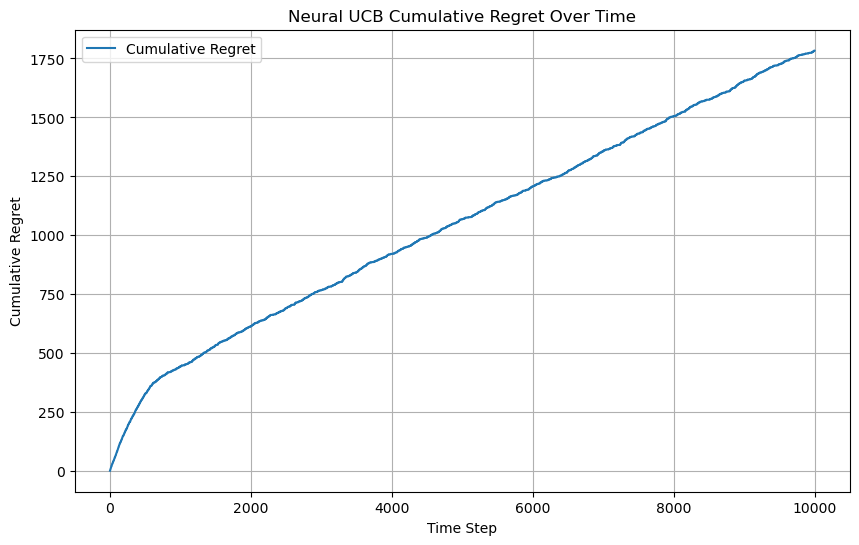

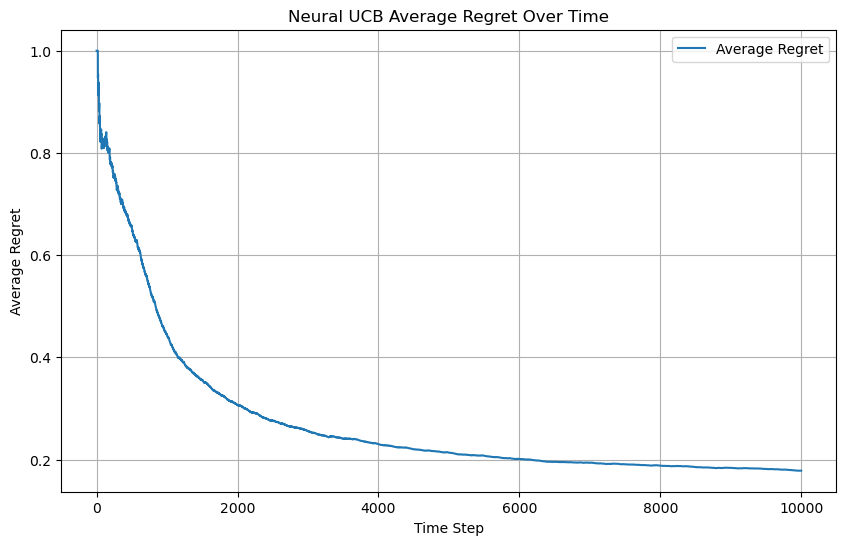

In [7]:
import matplotlib.pyplot as plt

def plot_regret(regret):
    # Convert to numpy array if it's a list
    regret = np.array(regret)
    
    # Plot cumulative regret
    plt.figure(figsize=(10, 6))
    cumulative_regret = np.cumsum(regret)
    plt.plot(cumulative_regret, label='Cumulative Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Regret')
    plt.title('Neural UCB Cumulative Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot average regret
    plt.figure(figsize=(10, 6))
    steps = np.arange(1, len(cumulative_regret) + 1)  # create step array first
    average_regret = cumulative_regret / steps
    plt.plot(average_regret, label='Average Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Average Regret')
    plt.title('Neural UCB Average Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
# After training:
plot_regret(regret)